# An implementation of the online Hidden Markov model with Gaussian observation model

In this notebook, we build the online hidden-Markov model (HMM) from a Bayesian perspective for
regime detection and prediction

In [1]:
import jax
import chex
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# Configure matplotlib for publication-quality figures with TeX
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (7.2, 3.0)
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

sns.set_palette("colorblind")

In [3]:
key = jax.random.PRNGKey(314) # 314
key_sample, key_run = jax.random.split(key)

(Hidden definition of new macros)
$\newcommand{\vP}{\boldsymbol P}$
$\newcommand{\d}{\rm d}$

## A hidden markov model

In [4]:
n_regimes = 3
transition_matrix_diag = jnp.ones(n_regimes) * 0.99
transition_matrix = jnp.ones((n_regimes, n_regimes)) * (1 - transition_matrix_diag) / (n_regimes - 1)
transition_matrix =transition_matrix.at[jnp.diag_indices(n_regimes)].set(transition_matrix_diag)

log_transition_matrix = jnp.log(transition_matrix)
means = jnp.array([-1, 0, 1]) * 2
n_regimes = len(means)

In [5]:
transition_matrix

Array([[0.99 , 0.005, 0.005],
       [0.005, 0.99 , 0.005],
       [0.005, 0.005, 0.99 ]], dtype=float32)

In [6]:
obs_var = 1.5 ** 2

def step(state, key):
    key_state, key_noise = jax.random.split(key)
    proba_change = transition_matrix[state]
    state_next = jax.random.choice(key, len(proba_change), p=proba_change)

    err = jax.random.normal(key_noise) * jnp.sqrt(obs_var)
    obs = means[state_next] + err

    return state_next, (state_next, obs)

In [7]:
state_init = 0
n_steps = 1500
timesteps = jnp.arange(n_steps)

keys = jax.random.split(key_sample, n_steps)
_, (states, obs) = jax.lax.scan(step, state_init, keys)

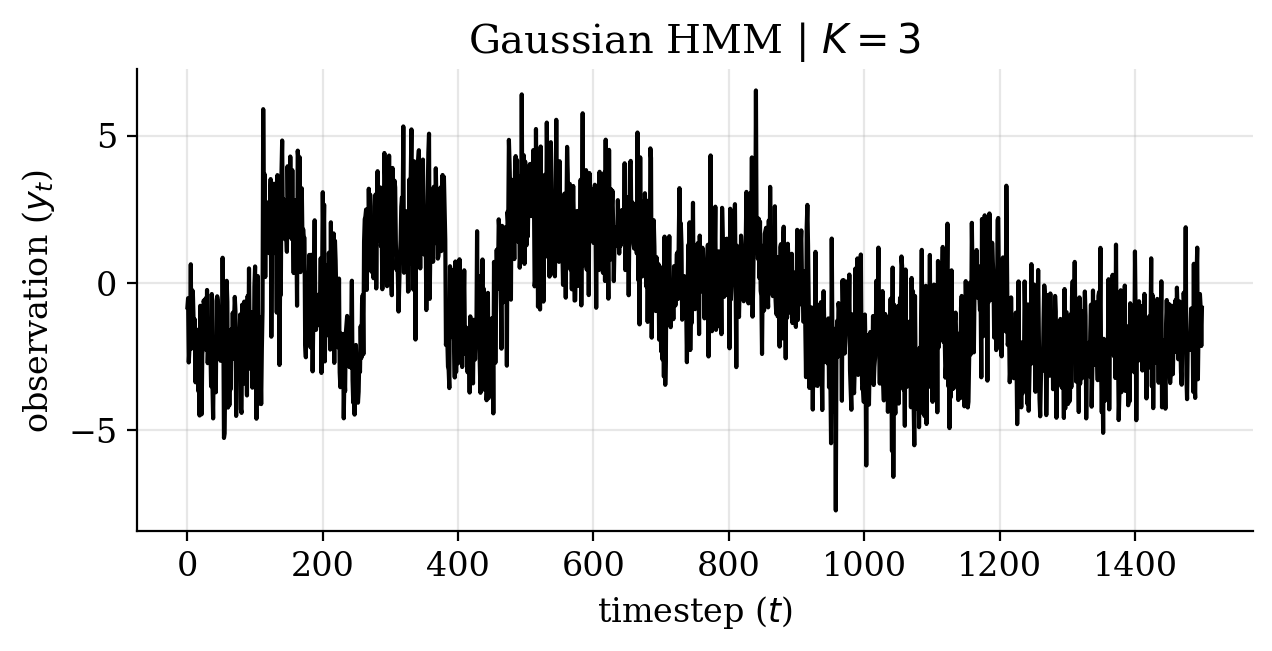

In [8]:
plt.plot(obs, c="black")
plt.xlabel("timestep ($t$)")
plt.ylabel("observation ($y_t$)")
plt.title("Gaussian HMM | $K=3$")
plt.grid(alpha=0.3)

## Updating beliefs with known regimes

In [9]:
@chex.dataclass
class BeliefRegimes:
    means: chex.Array
    variances: chex.Array

In [10]:
def update(y, mean, var, sigma2):
    """
    Make an update to the one-dimensional
    Gaussian-Gaussian model.
    """
    err = y - mean
    kt = var / (var + sigma2)
    mean_update = mean + kt * err
    var_update = (1 - kt) * var

    return mean_update, var_update


def update_conditional(bel, xs, sigma2):
    y, z = xs
    mean = bel.means[z]
    var = bel.variances[z]

    mean_update, var_update = update(y, mean, var, sigma2)

    bel_update = bel.replace(
        means=bel.means.at[z].set(mean_update),
        variances=bel.variances.at[z].set(var_update)
    )

    return bel_update, bel

In [11]:
bel_init = BeliefRegimes(means=jnp.zeros(n_regimes), variances=jnp.ones(n_regimes))
bel_final, bel_hist = jax.lax.scan(partial(update_conditional, sigma2=obs_var), bel_init, (obs, states))

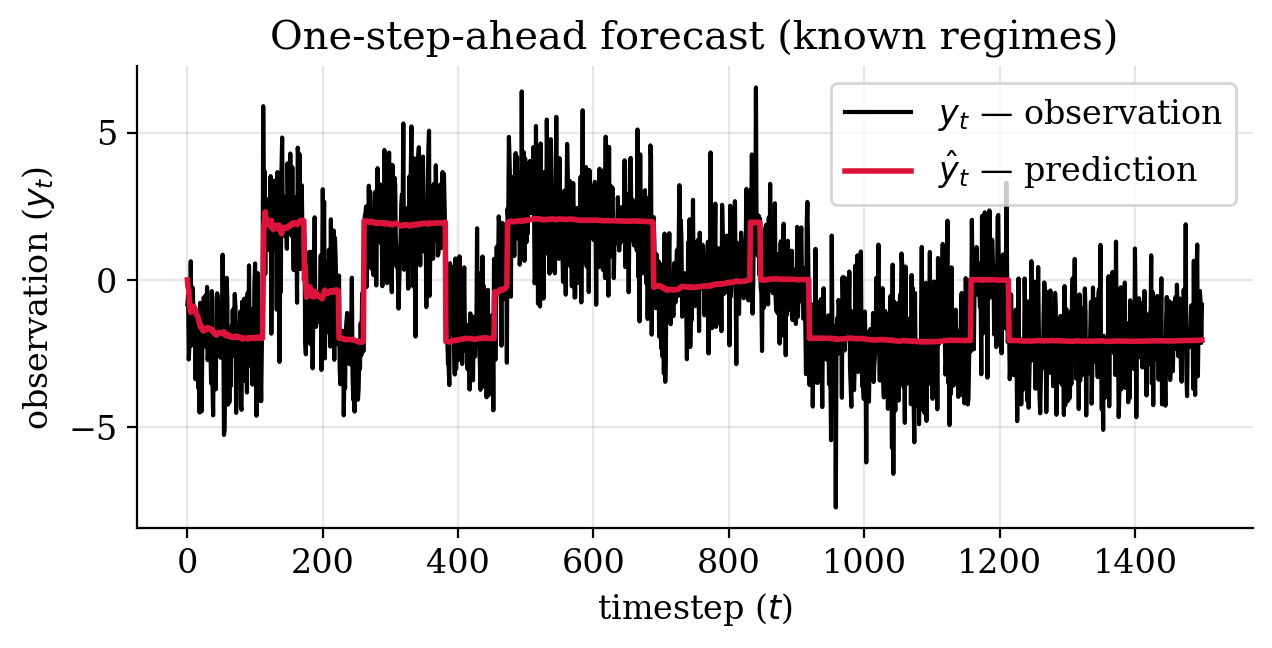

In [12]:
hist_preds = jnp.take_along_axis(bel_hist.means, states[:, None], axis=1)

plt.plot(obs, label="$y_t$ — observation", color="black")
plt.plot(hist_preds, label=r"$\hat{y}_t$ — prediction", linewidth=2, color="crimson")
plt.title("One-step-ahead forecast (known regimes)")
plt.xlabel("timestep ($t$)")
plt.ylabel("observation ($y_t$)")
plt.legend()
plt.grid(alpha=0.3)

## Regime identification (known model parameters)

## All together

In [13]:
obs_std = jnp.sqrt(obs_var)

In [14]:
@chex.dataclass
class HMMDetector:
    regimes: chex.Array
    log_weights: chex.Array

# Every regime is paired with a log_weight
@partial(jax.vmap, in_axes=(0, 0, None))
def update_log_weight(regime, log_weight, obs):
    log_transition = log_transition_matrix[regime]
    log_likelihoods = jax.scipy.stats.norm.logpdf(obs, means, obs_std)
    
    log_weight_new = log_weight + log_transition + log_likelihoods
    return log_weight_new


def step(bel, obs):
    log_weights_update = update_log_weight(bel.regimes, bel.log_weights, obs)
    log_weights_update = log_weights_update.ravel()

    ixs = jnp.argsort(log_weights_update, descending=True)[:S]
    regimes_new = ixs % n_regimes
    log_weights_new = log_weights_update[ixs]

    log_weights_new = log_weights_new - jax.nn.logsumexp(log_weights_new)

    bel = bel.replace(
        regimes=regimes_new,
        log_weights=log_weights_new
    )
    return bel, (regimes_new, log_weights_new)

## Single particle

In [15]:
S = 1
log_weights = jnp.zeros(S)
key_init, key_eval = jax.random.split(key)
regimes = jax.random.choice(key_init, n_regimes, (S,)) # initial regimes

bel = HMMDetector(
    regimes=regimes,
    log_weights=log_weights
)

bel_final, (hist_regimes, hist_log_weights) = jax.lax.scan(step, bel, obs)

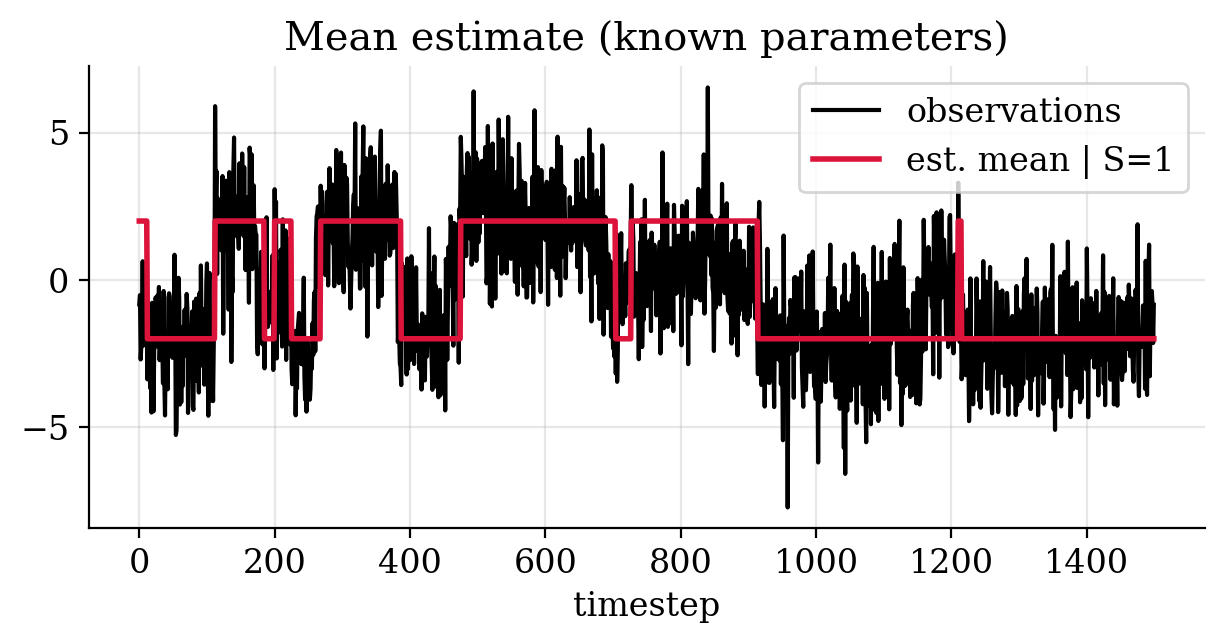

In [16]:
plt.plot(obs, c="black", label="observations")
plt.plot(means.at[hist_regimes.ravel()].get(), c="crimson", linewidth=2, label=f"est. mean | {S=}")
plt.legend()
plt.title("Mean estimate (known parameters)")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

## Multiple particles

In [17]:
S = 10
log_weights = jnp.zeros(S)
key_init, key_eval = jax.random.split(key)
regimes = jax.random.choice(key_init, n_regimes, (S,)) # initial regimes

bel = HMMDetector(
    regimes=regimes,
    log_weights=log_weights
)

bel_final, (hist_regimes, hist_log_weights) = jax.lax.scan(step, bel, obs)

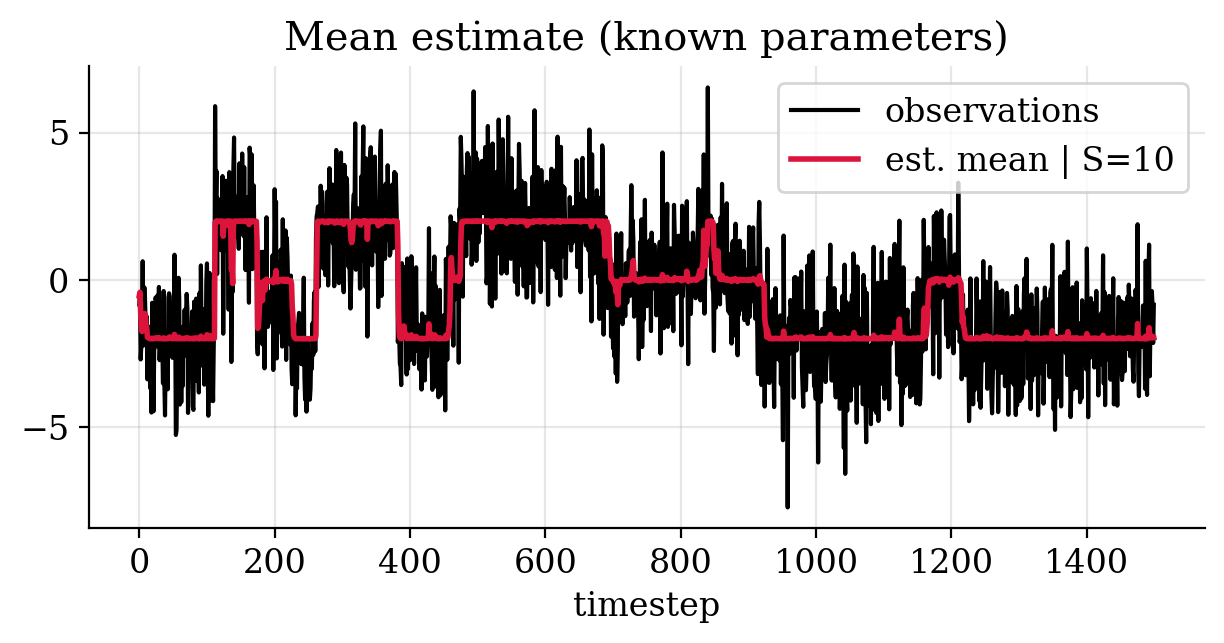

In [18]:
e_mean = (means.at[hist_regimes].get() * jnp.exp(hist_log_weights)).sum(axis=1)

plt.plot(obs, c="black", label="observations")
plt.plot(e_mean, c="crimson", linewidth=2, label=f"est. mean | {S=}")
plt.legend()
plt.xlabel("timestep")
plt.title("Mean estimate (known parameters)")
plt.grid(alpha=0.3)

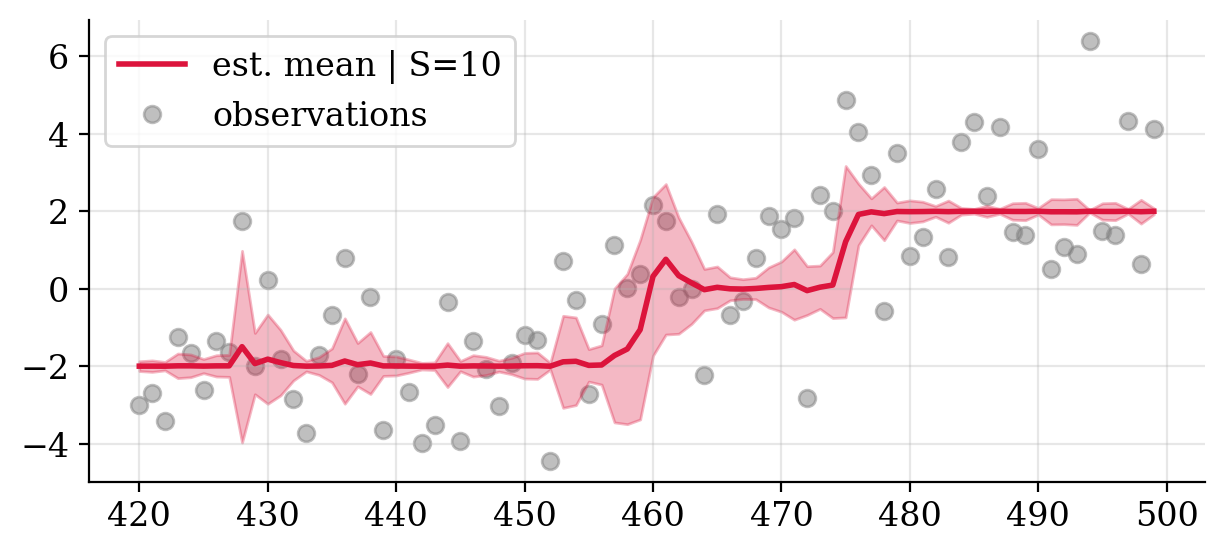

In [19]:
e2_mean = (means.at[hist_regimes].get() ** 2 * jnp.exp(hist_log_weights)).sum(axis=1)
est_std = jnp.sqrt(e2_mean - e_mean ** 2)

lbound = e_mean - 2 * est_std
ubound = e_mean + 2 * est_std
timesteps = jnp.arange(n_steps)
tslice = slice(420, 500)
plt.fill_between(timesteps[tslice], lbound[tslice], ubound[tslice], color="crimson", alpha=0.3)
plt.plot(timesteps[tslice], e_mean[tslice], c="crimson", linewidth=2, label=f"est. mean | {S=}")
plt.plot(timesteps[tslice], obs[tslice], zorder=0, c="gray", alpha=0.5, marker="o", linewidth=0, label="observations")
plt.legend()
plt.grid(alpha=0.3)

---

## Finite hidden state-space model (v.0)

Here, we assume the transition probabilities between latent states are known.
However, we do not know the location of the states and we do not know the mean value for each of the states.

Formally, we consider the following model
$$
\begin{aligned}
    p(s_t \mid s_{t-1}) &= \pi_{s_t,\,s_{t-1}}\\
    p(\Theta \mid s_t) &= {\cal N}(\theta_{s_t} \mid m_0,\,\sigma_0^2)\\
    p(y_t \mid \Theta, s_t) &= {\cal N}(y_t \mid \theta_{s_t},\,\sigma^2)
\end{aligned}
$$
with $\pi_{i,j}$ known for all $i,j$.

Let $\psi_t \in \Psi_t = \{1, 2, \ldots, K\}^t$
be an auxiliary variable denoting the history of regimes visited.

Starting at at a state $s_0 \in \{1, \ldots, K\}$,
the auxiliary variable is defined as $\psi_0 = \{s_0\}$.
After each step, the auxiliary variable is updated as
$\psi_t = \psi_{t-1} \cup \{s_t\}$ and $\psi_{t-1} = \{s_1, \ldots, s_{t-1}\}$

The possible history of regimes looks as follows
```python
[[1], [2], [3]]
-->
[[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]]
-->
[[1,1,1], [1,1,2], [1,1,3], [1,2,1], [1,2,2], [1,2,3], [1,3,1], [1,3,2], ...]
-->
...
```

In [20]:
@chex.dataclass
class ParticleState:
    means: jax.Array
    variances: jax.Array
    regime: jax.Array
    log_weight: jax.Array
    timestep: jax.Array

    @staticmethod
    def init(key, mean, cov, n_particles, n_regimes, n_steps):
        key_mean, key_regimes = jax.random.split(key)

        means = jax.random.normal(key_mean, (n_particles, n_regimes, 1)) * jnp.sqrt(cov)
        variances = einops.repeat(cov, "i -> s k i", s=n_particles, k=n_regimes)
        log_weights = jnp.full(n_particles, -jnp.log(n_particles))
        timestep = jnp.zeros(n_particles)

        regimes = jnp.zeros((n_particles, n_steps)).astype(int)
        regimes_init = jax.random.choice(key_regimes, n_regimes, (n_particles,)).astype(int)
        regimes = regimes.at[:, 0].set(regimes_init)
        
        return ParticleState(
            means=means, 
            variances=variances,
            regime=regimes,
            log_weight=log_weights,
            timestep=timestep,
        )


@chex.dataclass
class Cfg:
    var: float


def flatten_particles(tree):
    """
    Given any pytree with leaf shapes (particles options ...),
    we stack the leaf to be (particle options) ...
    """
    einops_expr = "particles options ... -> (particles options) ..."
    res = jax.tree.map(lambda x: einops.rearrange(x, einops_expr), tree)
    return res


def update(y, regime, bel, cfg):
    """
    Update model parameters for a regime
    """
    mean = bel.means[regime]
    var = bel.variances[regime]
    yhat = mean # f(mean, x) — observation mean function
    
    err = y - yhat
    kt = var / (var + cfg.var)
    mean_update = mean + kt * err
    var_update = (1 - kt) * var

    pred_sttdev = jnp.sqrt(var + cfg.var)
    log_pp = jax.scipy.stats.norm.logpdf(y, yhat, pred_sttdev).squeeze()

    timestep_new = bel.timestep + 1
    bel = bel.replace(
        means=bel.means.at[regime].set(mean_update),
        variances=bel.variances.at[regime].set(var_update),
        regime=bel.regime.at[timestep_new.astype(int)].set(regime),
        timestep=timestep_new,
    )
    return bel, (log_pp, yhat)

## Beam sampling

In [21]:
def _top_k(key, log_weights, bel, normalize=True):
    indices = jnp.argsort(log_weights, descending=True)[:n_particles]
    
    bel = bel.replace(
        log_weight=log_weights
    )
    
    bel = jax.tree.map(lambda x: x[indices], bel)

    if normalize:
        log_weights = bel.log_weight - jax.nn.logsumexp(bel.log_weight)
        bel = bel.replace(
            log_weight=log_weights
        )

    return bel


@partial(jax.vmap, in_axes=(None, 0, None))
def vstep_update(y, bel, cfg):
    """
    Update beliefs for all regimes
    """
    regimes = jnp.arange(n_regimes)
    regime_curr = bel.regime[bel.timestep.astype(int)]
    log_p_transition = log_transition_matrix[regime_curr, regimes]
    
    update_vmap = jax.vmap(update, in_axes=(None, 0, None, None))
    bel_update, (log_pp, mean_pred) = update_vmap(y, regimes, bel, cfg)

    return bel_update, (log_pp, log_p_transition, mean_pred)


def step_optimal(bel, xs, cfg):
    y, key = xs
    bel_update, (log_pp, log_p_transition, mean_pred_all) = vstep_update(y, bel, cfg)

    log_weights = log_pp + log_p_transition + bel.log_weight[:, None]
    bel_update, log_weights, mean_pred_all = flatten_particles((bel_update, log_weights, mean_pred_all))
    
    # Prediced mean
    mean_pred_all = mean_pred_all.ravel()
    weights_pred = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    predicted_mean = (weights_pred[:, None] * mean_pred_all).sum(axis=0)
    
    bel_update = _top_k(key, log_weights, bel_update)
    

    return bel_update, (bel_update.log_weight, bel_update.means, bel_update.variances)

In [22]:
@jax.vmap
def build_weights(log_weights):
    log_weights_norm = log_weights - jax.nn.logsumexp(log_weights)
    return jnp.exp(log_weights_norm)

### Run

In [23]:
n_particles = 5
mean_init = jnp.array([0.0])
var_init = jnp.array([0.1]) 

key_init, key_eval = jax.random.split(key_run)
bel_init = ParticleState.init(key_init, mean_init, var_init, n_particles, n_regimes, n_steps)
jax.tree.map(jnp.shape, bel_init)

ParticleState(means=(5, 3, 1), variances=(5, 3, 1), regime=(5, 1500), log_weight=(5,), timestep=(5,))

In [24]:
cfg = Cfg(var=obs_var)
keys = jax.random.split(key_eval, n_steps)
Xs = (obs, keys)
_step = partial(step_optimal, cfg=cfg)
bel_final, (hist_lw, hist_mean, hist_variance) = jax.lax.scan(_step, bel_init, Xs)

In [25]:
hist_weights = build_weights(hist_lw)

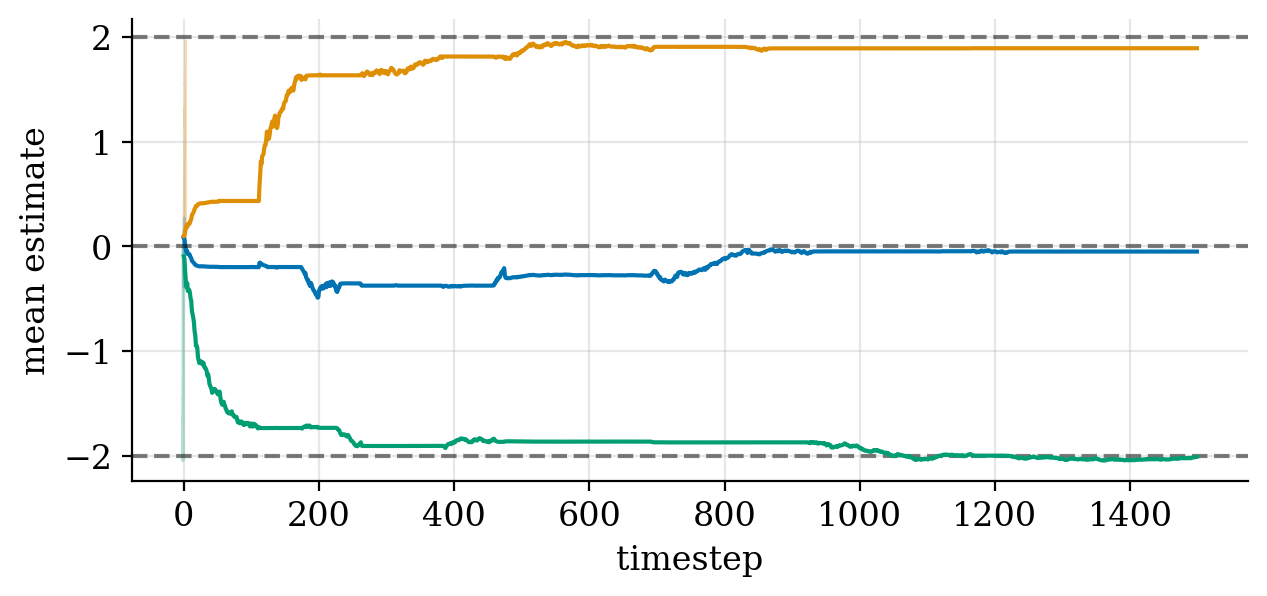

In [26]:
mean_est = jnp.einsum("ts,tsk...->tk", hist_weights, hist_mean)
hist_std = jnp.einsum("ts,tsk...->tk", hist_weights, hist_variance)

colors = sns.color_palette()
for i, mean in enumerate(means):
    std_i = hist_std[:, i]
    mean_i = mean_est[:, i]
    lbound, ubound = mean_i - 2 * std_i, mean_i + 2 * std_i
    plt.fill_between(lbound, ubound, color=colors[i], alpha=0.3)
    plt.plot(timesteps, mean_i, c=colors[i])
    plt.axhline(y=mean, c="black", linestyle="--", alpha=0.5)
plt.ylabel("mean estimate")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

In [27]:
hist_regime = jax.nn.one_hot(bel_final.regime, n_regimes, axis=0)

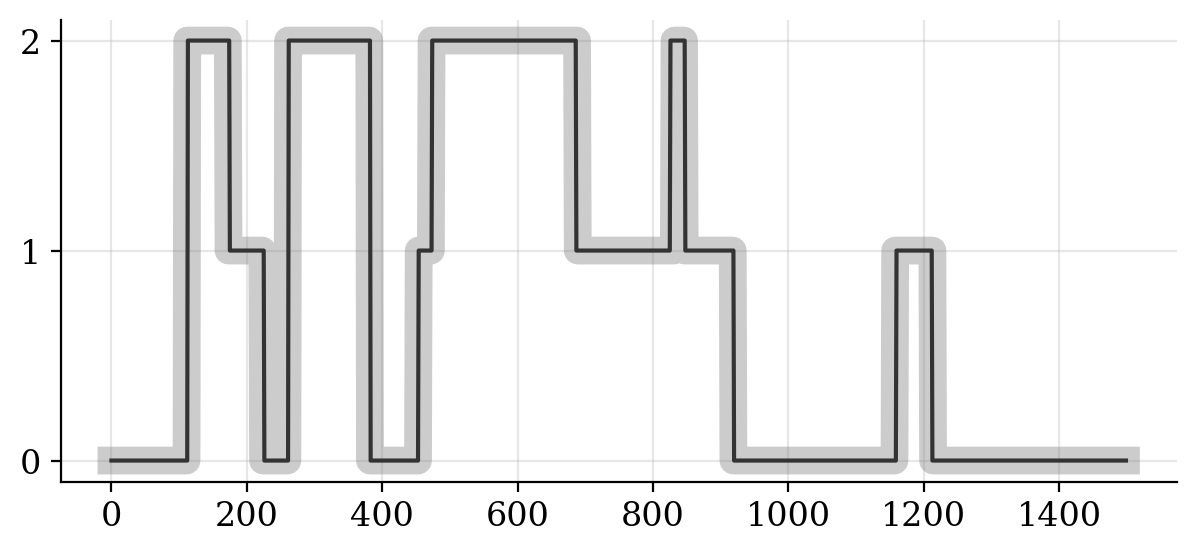

In [28]:
proba_regimes = jnp.einsum(
    "kst,ts->tk",
    hist_regime[[2,0,1], ...],
    hist_weights
)
# plt.step(timesteps, states, label="true state", where="post", c="tab:gray", linewidth=10, alpha=0.3)

plt.plot(proba_regimes.argmax(axis=1), c="black")

plt.plot(states, c="gray", linewidth=10, alpha=0.4)
plt.yticks([0, 1, 2])
plt.grid(alpha=0.3)

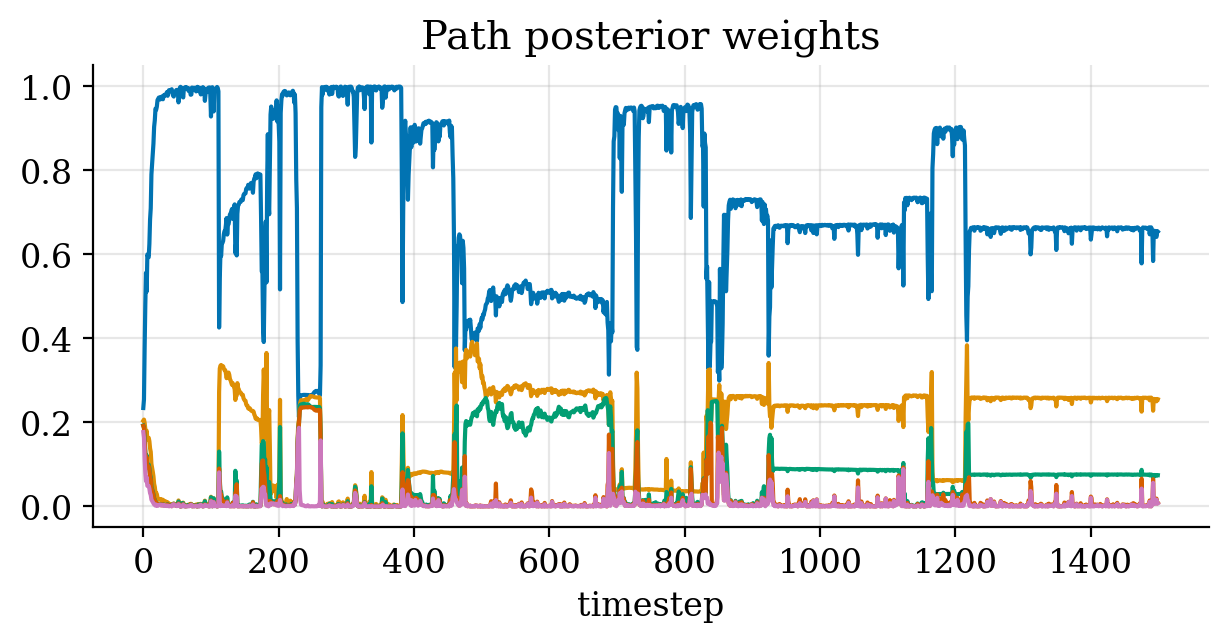

In [29]:
# Lower is better
plt.title("Path posterior weights")
plt.plot(hist_weights)
plt.xlabel("timestep")
plt.grid(alpha=0.3)

$$
    \hat{y}_t = \sum_{s=1}^S\sum_{k=1}^K m_{t,k}^{(s)}\;w_t^{(s)}
$$

In [30]:
pmean_est = jnp.einsum(
    "tsk...,kst,ts->t",
    hist_mean,
    hist_regime,
    hist_weights
)

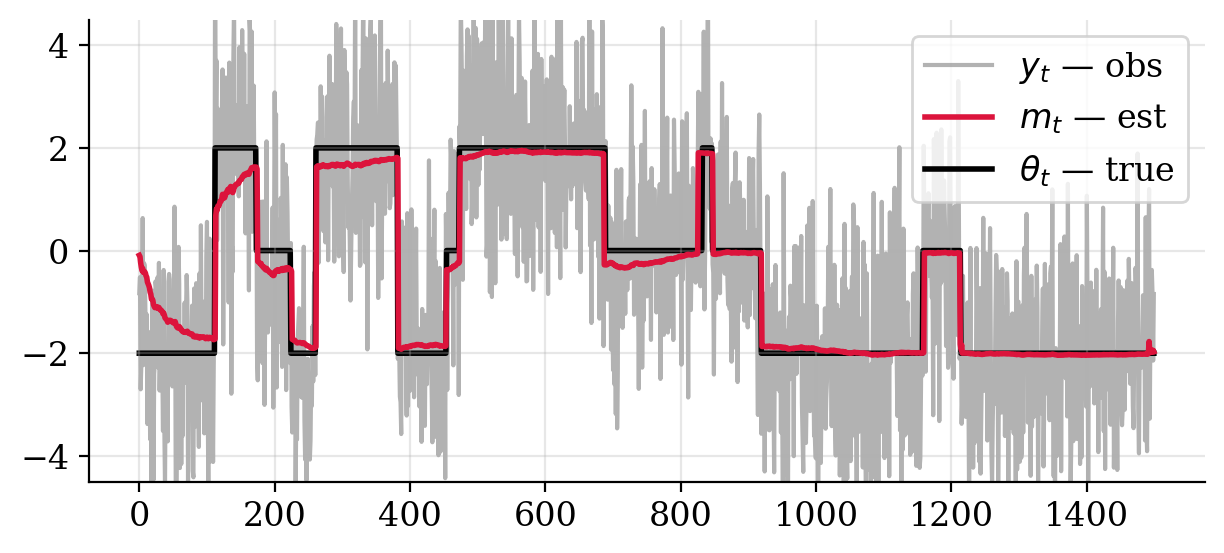

In [31]:
plt.plot(obs, c="gray", alpha=0.6, label="$y_t$ — obs", zorder=0)
plt.plot(pmean_est, c="crimson", linewidth=2, label="$m_t$ — est")
plt.plot(means.at[states].get(), c="black", zorder=1, linewidth=2, label=r"$\theta_t$ — true")
plt.legend()
plt.ylim(-4.5, 4.5)
plt.grid(alpha=0.3)

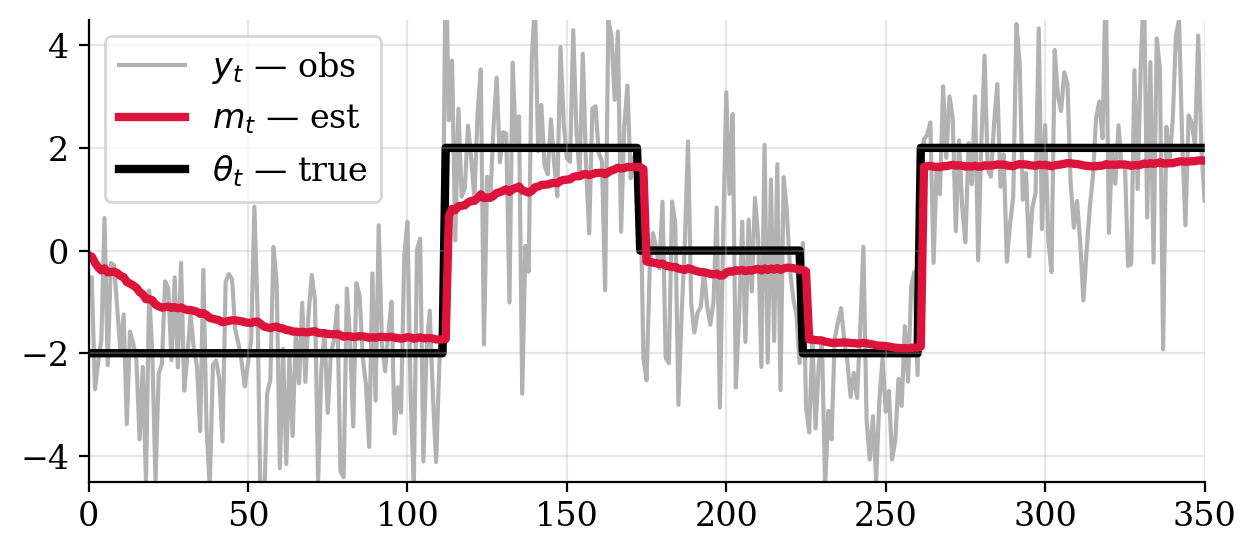

In [32]:
# One could warmup / use the initial data as "pre-training" period
plt.plot(obs, c="gray", alpha=0.6, label="$y_t$ — obs", zorder=0)
plt.plot(pmean_est, c="crimson", label="$m_t$ — est", linewidth=3)
plt.plot(means.at[states].get(), c="black", zorder=1, linewidth=3, label=r"$\theta_t$ — true")
plt.legend()
plt.xlim(0, 350)
plt.ylim(-4.5, 4.5)
plt.grid(alpha=0.3)

## Sequential Monte Carlo (SMC)

In [33]:
def multinomial_resampling(key, log_weights, n_particles):
    indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    return indices


def _resample(key, log_weights, bel):
    """
    Resample particles if the effective sample size (ESS)
    is below some threshold according to their log-weights
    """
    indices = multinomial_resampling(key, log_weights, n_particles)

    # Update new belief
    bel = jax.tree.map(lambda x: x[indices], bel)
    
    # Reset particles
    bel = bel.replace(
        log_weight=jnp.repeat(-jnp.log(n_particles), n_particles)
    )
    return bel



def _continue(key, log_weights, bel):
    bel = bel.replace(
        log_weight=log_weights
    )
    return bel


@partial(jax.vmap, in_axes=(0, None, 0, None))
def step_update(key, y, bel, cfg):
    """
    Sample regime and update
    """
    regime_curr = bel.regime[bel.timestep.astype(int)]
    log_p_transition = log_transition_matrix[regime_curr]
    regime_next = jax.random.categorical(key, log_p_transition)

    bel_update, (log_pp, mean_pred) = update(y, regime_next, bel, cfg)

    return bel_update, (log_pp, mean_pred)


def step_sample(bel, xs, cfg):
    y, key = xs
    
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    
    bel_update, (log_pp, mean_pred_all) = step_update(keys, y, bel, cfg)
    log_weights = log_pp + bel.log_weight

    # Prediced mean
    weights_pred = jnp.exp(log_weights - jax.nn.logsumexp(log_weights))

    # Update weights, compute the effective sample size
    ess = 1 / jnp.sum(weights_pred ** 2)

    ### Resample step ###
    bel_update = jax.lax.cond(
        ess < n_particles * 0.5,
        _resample,
        _continue,
        key_resample, log_weights, bel_update
    )

    weights = jnp.exp(bel.log_weight - jax.nn.logsumexp(bel.log_weight))
    mean_position = jnp.einsum("s...,s->...", bel.means, weights)
    

    return bel_update, (log_weights, mean_position, mean_pred_all, ess)

In [34]:
n_particles = 100
mean_init = jnp.array([0.0])
var_init = jnp.array([0.1]) 

key_init, key_eval = jax.random.split(key_run)
bel_init = ParticleState.init(key_init, mean_init, var_init, n_particles, n_regimes, n_steps)
jax.tree.map(jnp.shape, bel_init)

ParticleState(means=(100, 3, 1), variances=(100, 3, 1), regime=(100, 1500), log_weight=(100,), timestep=(100,))

In [35]:
%%time
cfg = Cfg(var=obs_var)
keys = jax.random.split(key_eval, n_steps)
Xs = (obs, keys)
_step = partial(step_sample, cfg=cfg)
bel_final, (hist_ll, hist_mean, hist_target_mean, hist_ess) = jax.lax.scan(_step, bel_init, Xs)
hist_mean = hist_mean.squeeze()
hist_target_mean = hist_target_mean.squeeze()
hist_ll = jax.block_until_ready(hist_ll)

CPU times: user 984 ms, sys: 59.5 ms, total: 1.04 s
Wall time: 250 ms


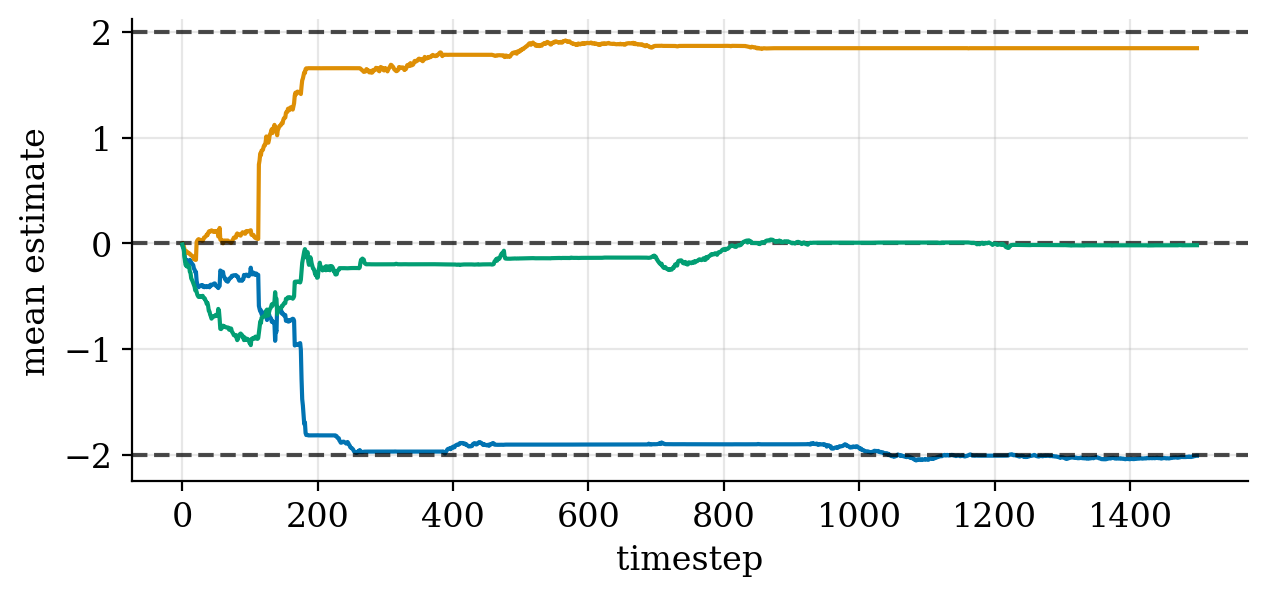

In [36]:
colors = sns.color_palette()
for i, mean in enumerate(means):
    mean_i = hist_mean[:, i]
    std_i = hist_std[:, i]
    # lbound, ubound = mean_i - 2 * std_i, mean_i + 2 * std_i
    plt.plot(timesteps, mean_i, c=colors[i])
    # plt.fill_between(timesteps, lbound, ubound, alpha=0.3)
    plt.axhline(y=mean, c="black", linestyle="--", alpha=0.7)
plt.ylabel("mean estimate")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

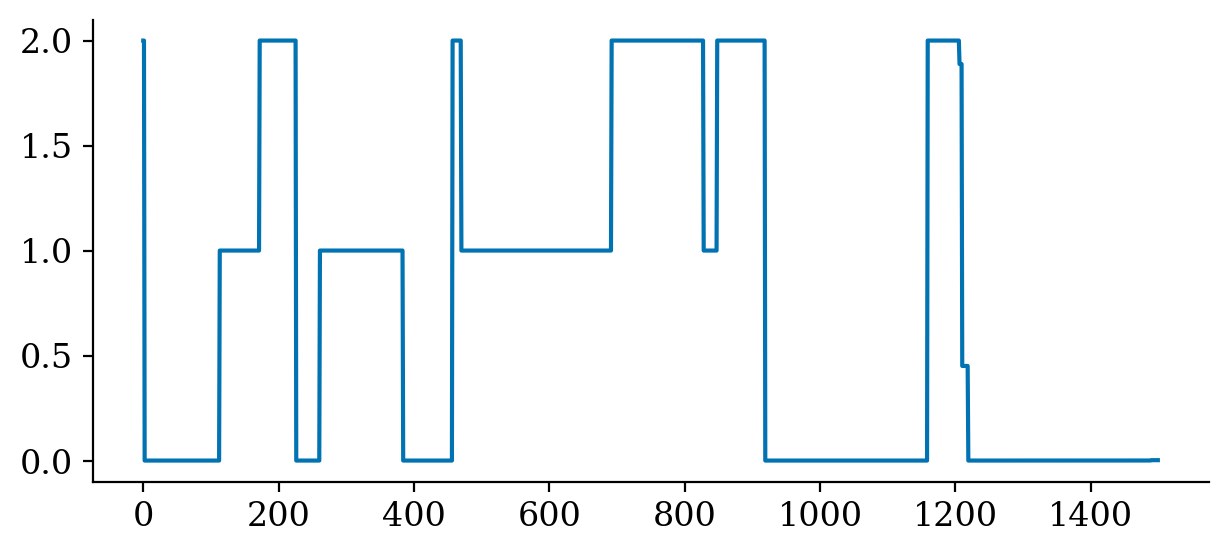

In [37]:
weights_final = jnp.exp(bel_final.log_weight - jax.nn.logsumexp(bel_final.log_weight))

plt.plot((bel_final.regime * weights_final[..., None]).sum(axis=0))

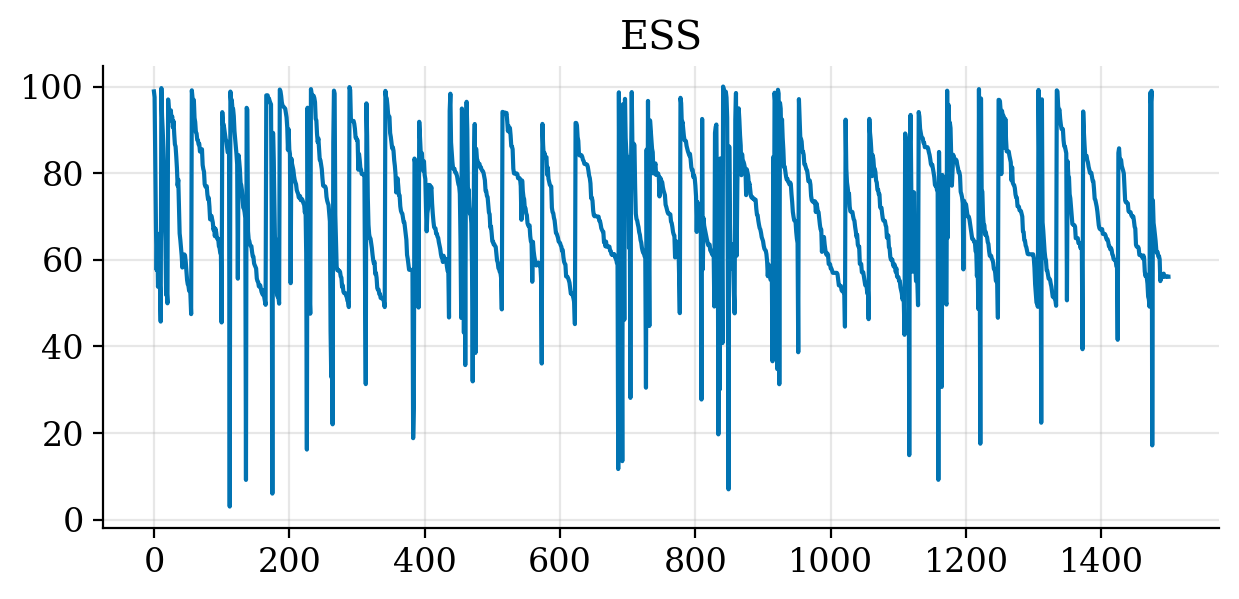

In [38]:
plt.plot(hist_ess)
plt.title("ESS")
plt.grid(alpha=0.3)

In [39]:
nll = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)

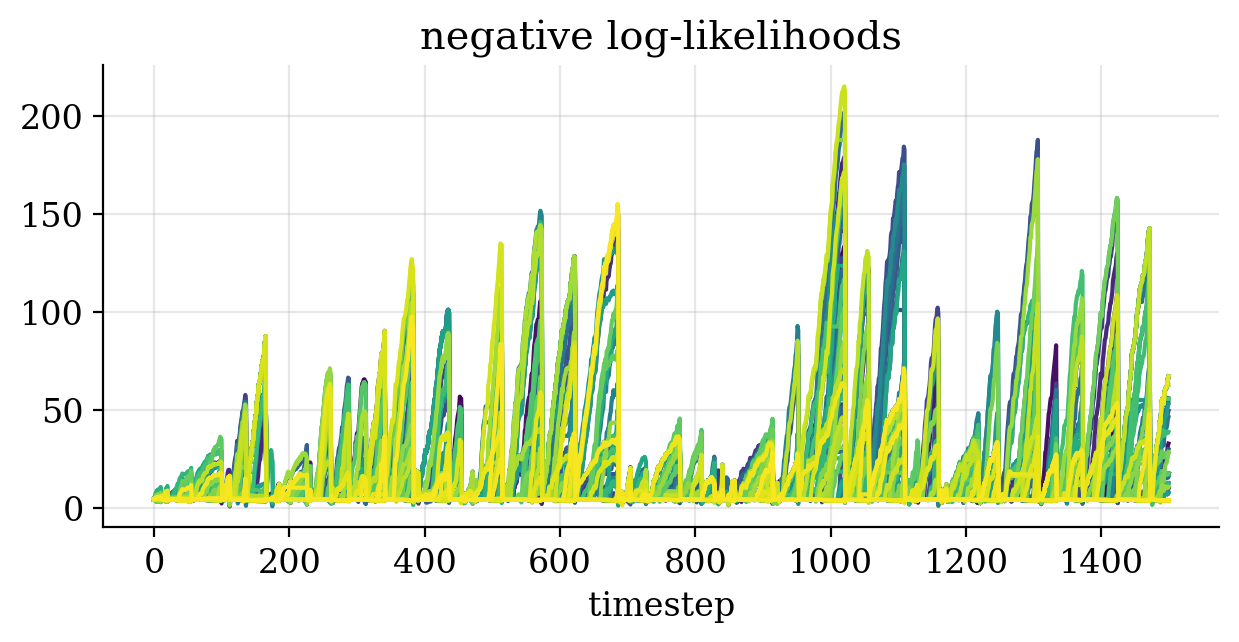

In [40]:
sns.lineplot(-nll, palette="viridis", legend=False, dashes=False)
plt.title("negative log-likelihoods")
plt.xlabel("timestep")
plt.grid(alpha=0.3)

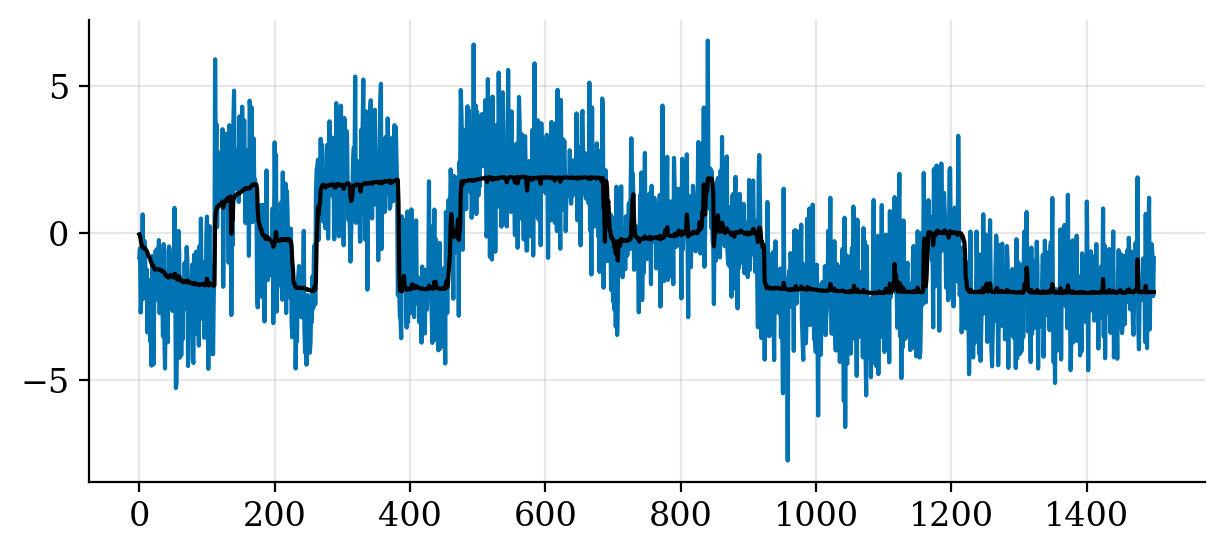

In [41]:
hist_ll_normed = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)

plt.plot(obs)
plt.plot((hist_target_mean * jnp.exp(hist_ll_normed)).sum(axis=1), c="black")
plt.grid(alpha=0.3)

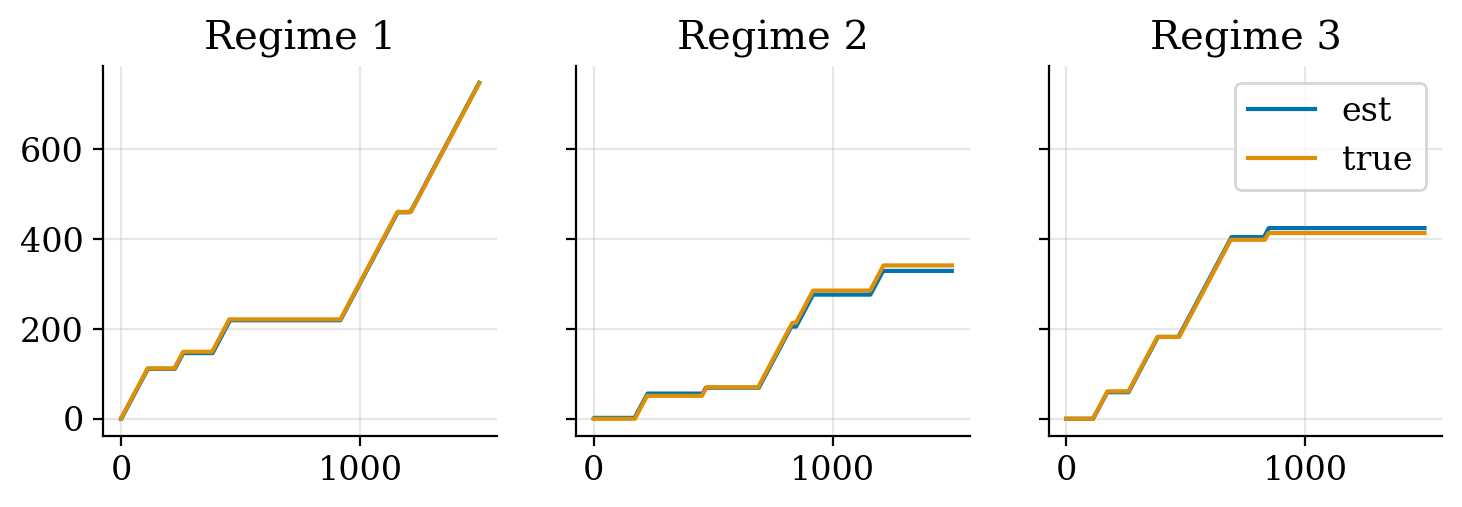

In [42]:
regimes_est_ohe = (jax.nn.one_hot(bel_final.regime.T, 3,) * weights_final[..., None]).sum(axis=1)
regimes_est_ohe = regimes_est_ohe[:, [0, 2, 1]] # Permutation is run-specific
regimes_est_count = regimes_est_ohe.cumsum(axis=0)
regimes_true_count = jax.nn.one_hot(states, 3).cumsum(axis=0)

ix = 0
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7.2 * 1.2, 3.0 * 0.8))
for ix, ax in enumerate(axs):
    ax.plot(regimes_est_count[:, ix], label="est")
    ax.plot(regimes_true_count[:, ix], label="true")
    ax.set_title(f"Regime {ix+1}")
    ax.grid(alpha=0.3)
plt.legend()

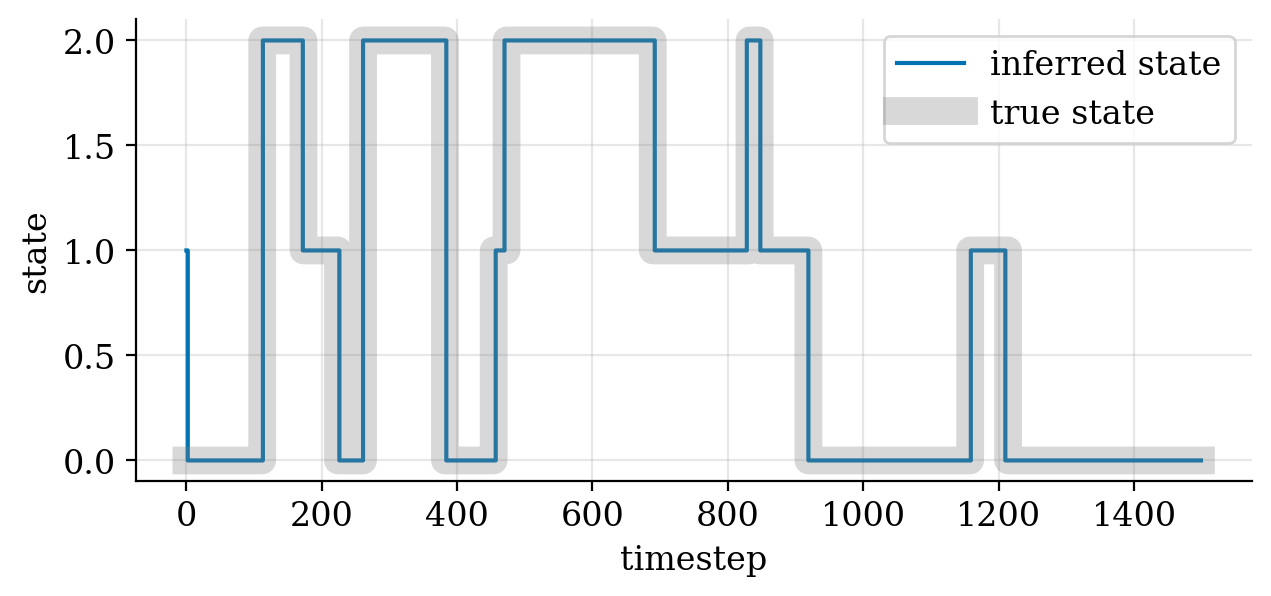

In [43]:
plt.step(timesteps, regimes_est_ohe.argmax(axis=1), label="inferred state", where="post")
plt.step(timesteps, states, label="true state", where="post", c="tab:gray", linewidth=10, alpha=0.3)
plt.ylabel("state")
plt.xlabel("timestep")
plt.legend()
plt.grid(alpha=0.3)